# Flux.1-dev 网络结构详解

![](https://image-1304830922.cos.ap-shanghai.myqcloud.com/20250302232842466.jpeg)

## 输入准备

根据我们的 Diffusion 三要素理论，在 Sampling 的时候其实只需要确定反向更新公式即可，而 RF 的公式极为简单，Flux.1 也完全是符合我们上一节的内容。

```python
for t_curr, t_prev in zip(timesteps[:-1], timesteps[1:]):
    t_vec = torch.full((img.shape[0],), t_curr, dtype=img.dtype, device=img.device)
    pred = model(
        img=img,
        img_ids=img_ids,
        txt=txt,
        txt_ids=txt_ids,
        y=vec,
        timesteps=t_vec,
        guidance=guidance_vec,
    )

    img = img + (t_prev - t_curr) * pred
```

在模型的输入部分，我们需要确定：

- `img`: latent中的image，`size=[bs, (h*w/16/16), 16*2*2]`
  - 在 VAE 中，压缩比为 16，通道数也为 16
  - 在 VAE 之前做了 patch 化，比例是 2
- `img_ids`: 图像位置编码，`size=[bs, (h*w/16/16), 3]`
  - 位置编码是 3 维的，从 (0,0,0) 到 (0, h/16, w/16)
  - 第 1 维始终是空置的
- `txt`: prompt 的 T5 的 last_hidden_state，`size=[bs, max_length, 4096]`
  - max_length 默认是 512，也可以截断到更小值
- `txt_ids`: 文本位置编码，`size=[bs, max_length, 3]`
  - 全部设置为 (0,0,0)
- `vec`: prompt 的 CLIP 的 pooler_output，`size=[bs, 768]`
  - 是 global feature
- `timesteps`: 当前 timesteps，`size=[bs]`
- `guidance_vec`: 使用的 guidance，`size=[bs]`

### 文本编码器

In [ ]:
# 配置一下 huggingface 的环境变量
%env HF_ENDPOINT=https://hf-mirror.com
%env HF_HOME=/data1/cache/huggingface

env: HF_ENDPOINT=https://hf-mirror.com
env: HF_HOME=/data1/cache/huggingface


In [2]:
import math
import torch
from torch import Tensor, nn
from einops import rearrange, repeat
import matplotlib.pyplot as plt
from transformers import CLIPTextModel, CLIPTokenizer, T5EncoderModel, T5Tokenizer


class HFEmbedder(nn.Module):
    def __init__(self, version: str, max_length: int, **hf_kwargs):
        super().__init__()
        self.is_clip = version.startswith("openai")
        self.max_length = max_length
        self.output_key = "pooler_output" if self.is_clip else "last_hidden_state"

        if self.is_clip:
            self.tokenizer: CLIPTokenizer = CLIPTokenizer.from_pretrained(version, max_length=max_length)
            self.hf_module: CLIPTextModel = CLIPTextModel.from_pretrained(version, **hf_kwargs)
        else:
            self.tokenizer: T5Tokenizer = T5Tokenizer.from_pretrained(version, max_length=max_length)
            self.hf_module: T5EncoderModel = T5EncoderModel.from_pretrained(version, **hf_kwargs)

        self.hf_module = self.hf_module.eval().requires_grad_(False)

    def forward(self, text: list[str]) -> Tensor:
        batch_encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            return_length=False,
            return_overflowing_tokens=False,
            padding="max_length",
            return_tensors="pt",
        )

        outputs = self.hf_module(
            input_ids=batch_encoding["input_ids"].to(self.hf_module.device),
            attention_mask=None,
            output_hidden_states=False,
        )
        return outputs[self.output_key]

def load_t5(device: str | torch.device = "cuda", max_length: int = 512) -> HFEmbedder:
    # max length 64, 128, 256 and 512 should work (if your sequence is short enough)
    return HFEmbedder("google/t5-v1_1-xxl", max_length=max_length, torch_dtype=torch.bfloat16).to(device)

def load_clip(device: str | torch.device = "cuda") -> HFEmbedder:
    return HFEmbedder("openai/clip-vit-large-patch14", max_length=77, torch_dtype=torch.bfloat16).to(device)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_device = torch.device(device)
t5 = load_t5(torch_device, max_length=512)
clip = load_clip(torch_device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [4]:
bs = 2
prompt = ["A Hero"]*bs

txt = t5(prompt)
txt_ids = torch.zeros(bs, txt.shape[1], 3).to(torch_device)
y = clip(prompt)

print(txt.size(), y.size(), txt_ids.size())

torch.Size([2, 512, 4096]) torch.Size([2, 768]) torch.Size([2, 512, 3])


### img_ids 图像位置编码

注意这里的图块化操作，即 img 原本是 (bs, 16, h/8, w/8) 这个样子，但是 flux 将 2\*2=4 的区域视为一个图块，并将其 channel 拼接，形成 (bs, 16\*2\*2, h/16, w/16) 的形状。所谓的 ph, pw 即 patchify_height, patchify_width。

In [5]:
height = 512
width = 512
# allow for packing and conversion to latent space
height = 16 * (height // 16)
width = 16 * (width // 16)

img = torch.randn(
        bs,
        16,
        # allow for packing
        2 * math.ceil(height / 16),
        2 * math.ceil(width / 16),
        device=device,
        dtype=torch.bfloat16
    )
bs, c, h, w = img.shape

img = rearrange(img, "b c (h ph) (w pw) -> b (h w) (c ph pw)", ph=2, pw=2)

img_ids = torch.zeros(h // 2, w // 2, 3)
img_ids[..., 1] = img_ids[..., 1] + torch.arange(h // 2)[:, None]
img_ids[..., 2] = img_ids[..., 2] + torch.arange(w // 2)[None, :]
img_ids = repeat(img_ids, "h w c -> b (h w) c", b=bs).to(torch_device)

print(img.size(), img_ids.size())

torch.Size([2, 1024, 64]) torch.Size([2, 1024, 3])


### timesteps

In [6]:
from typing import Callable

def time_shift(mu: float, sigma: float, t: Tensor):
    return math.exp(mu) / (math.exp(mu) + (1 / t - 1) ** sigma)


def get_lin_function(
    x1: float = 256, y1: float = 0.5, x2: float = 4096, y2: float = 1.15
) -> Callable[[float], float]:
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return lambda x: m * x + b


def get_schedule(
    num_steps: int,
    image_seq_len: int,
    base_shift: float = 0.5,
    max_shift: float = 1.15,
    shift: bool = True,
) -> list[float]:
    # extra step for zero
    timesteps = torch.linspace(1, 0, num_steps + 1)

    # shifting the schedule to favor high timesteps for higher signal images
    if shift:
        # estimate mu based on linear estimation between two points
        mu = get_lin_function(y1=base_shift, y2=max_shift)(image_seq_len)
        timesteps = time_shift(mu, 1.0, timesteps)

    return timesteps.tolist()

num_steps = 50
timesteps = get_schedule(num_steps, img.shape[1], shift=True)

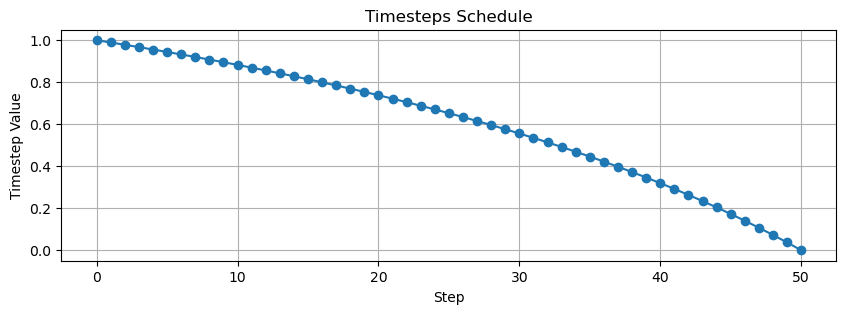

In [7]:
plt.figure(figsize=(10, 3))
plt.plot(timesteps, marker='o', linestyle='-')
plt.title('Timesteps Schedule')
plt.xlabel('Step')
plt.ylabel('Timestep Value')
plt.grid(True)
plt.show()

In [10]:
guidance = 4.0
guidance_vec = torch.full((img.shape[0],), guidance, device=img.device, dtype=img.dtype)
t_vec = torch.full((img.shape[0],), timesteps[0], dtype=img.dtype, device=img.device)

为了方便调试，我们可以把输入都保存下来，之后再 load 进来，就不用每次都 load T5 了。

In [11]:
inputs = {
    'img': img,
    'img_ids': img_ids,
    'txt': txt,
    'txt_ids': txt_ids,
    'timesteps': timesteps,
    't_vec': t_vec,
    'y': y,
    'guidance_vec': guidance_vec
}

# 保存张量数据
torch.save(inputs, 'inputs.pt')

In [13]:
print(img.size(), img_ids.size(), txt.size(), txt_ids.size(), t_vec.size(), y.size(), guidance_vec.size())

torch.Size([2, 1024, 64]) torch.Size([2, 1024, 3]) torch.Size([2, 512, 4096]) torch.Size([2, 512, 3]) torch.Size([2]) torch.Size([2, 768]) torch.Size([2])


## 网络 - 加载

这里由于 24G 显存加载不进去，我们把 depth 都调小了，因此也没有再加载原参数。仅为探究网络结构的话，参数本身不是很重要。

In [1]:
import math
import torch
from torch import Tensor, nn
from einops import rearrange, repeat
import matplotlib.pyplot as plt
from flux.model import Flux, FluxParams


flux_params=FluxParams(
            in_channels=64,
            out_channels=64,
            vec_in_dim=768,
            context_in_dim=4096,
            hidden_size=3072,
            mlp_ratio=4.0,
            num_heads=24,
            depth=2,  # should be 19
            depth_single_blocks=2,  # should be 38
            axes_dim=[16, 56, 56],
            theta=10_000,
            qkv_bias=True,
            guidance_embed=True,
        )

device = "cuda" if torch.cuda.is_available() else "cpu"
torch_device = torch.device(device)
with torch.device(device):
    model = Flux(flux_params).to(torch.bfloat16)


# 如下是加载模型的代码
# from huggingface_hub import hf_hub_download
# from safetensors.torch import load_file as load_sft

# ckpt_path = hf_hub_download("black-forest-labs/FLUX.1-dev", "flux1-dev.safetensors")
# state_dict = load_sft(ckpt_path, device=str(device))

# for name, param in model.named_parameters():
#     if name in state_dict:
#         if state_dict[name].shape != param.shape:
#             print(f"Expanding '{name}' with shape {state_dict[name].shape} to model parameter with shape {param.shape}.")
#             # expand with zeros:
#             expanded_state_dict_weight = torch.zeros_like(param, device=state_dict[name].device)
#             slices = tuple(slice(0, dim) for dim in state_dict[name].shape)
#             expanded_state_dict_weight[slices] = state_dict[name]
#             state_dict[name] = expanded_state_dict_weight

# model.load_state_dict(state_dict, strict=False, assign=True)

In [16]:
# 加载张量数据
inputs = torch.load('inputs.pt')
img = inputs['img']
img_ids = inputs['img_ids']
txt = inputs['txt']
txt_ids = inputs['txt_ids']
timesteps = inputs['timesteps']
t_vec = inputs['t_vec']
y = inputs['y']
guidance_vec = inputs['guidance_vec']

/tmp/ipykernel_1451177/1652036724.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inputs = torch.load('inputs.pt')


## （可选）网络 - 可视化

In [3]:
# 测试一下模型是否可以正常运行
pred = model(
    img=img,
    img_ids=img_ids,
    txt=txt,
    txt_ids=txt_ids,
    y=y,
    timesteps=t_vec,
    guidance=guidance_vec,
)

from torchviz import make_dot
# make_dot(pred.mean(), params=dict(model.named_parameters()))

### Netron

In [17]:
# 导出模型到 onnx，并用 https://netron.app/ 进行可视化
input_names = ["img", "img_ids", "txt", "txt_ids", "timesteps", "y", "guidance"]
output_names = ["output"]
model.eval()

torch.onnx.export(
    model,
    (img, img_ids, txt, txt_ids, t_vec, y, guidance_vec),
    "flux_model.onnx",
    input_names=input_names,
    output_names=output_names,
    opset_version=17,  # 你可以根据需要调整 opset 版本
    do_constant_folding=True,  # 是否执行常量折叠以优化模型
    dynamic_axes={
        "img": {0: "batch_size"},
        "img_ids": {0: "batch_size"},
        "txt": {0: "batch_size"},
        "txt_ids": {0: "batch_size"},
        "timesteps": {0: "batch_size"},
        "y": {0: "batch_size"},
        "guidance": {0: "batch_size"},
        "output": {0: "batch_size"},
    },
)

/root/codes/flux/src/flux/modules/layers.py:166: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  img_q, img_k, img_v = rearrange(img_qkv, "B L (K H D) -> K B H L D", K=3, H=self.num_heads)
/root/codes/flux/src/flux/modules/layers.py:173: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  txt_q, txt_k, txt_v = rearrange(txt_qkv, "B L (K H D) -> K B H L D", K=3, H=self.num_heads)
/root/codes/flux/src/flux/modules/layers.py:232: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect res

### torchinfo

In [4]:
# 使用torchinfo进行可视化
from torchinfo import summary

res = summary(model,
        input_data=[img, img_ids, txt, txt_ids, t_vec, y, guidance_vec],
        col_names=["input_size", "output_size", "num_params", "params_percent"],
        row_settings=["var_names"],
        depth=10,
        verbose=1,
)

Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Param %
Flux (Flux)                                        [2, 1024, 64]             [2, 1024, 64]             --                             --
├─Linear (img_in)                                  [2, 1024, 64]             [2, 1024, 3072]           199,680                     0.02%
├─MLPEmbedder (time_in)                            [2, 256]                  [2, 3072]                 --                             --
│    └─Linear (in_layer)                           [2, 256]                  [2, 3072]                 789,504                     0.08%
│    └─SiLU (silu)                                 [2, 3072]                 [2, 3072]                 --                             --
│    └─Linear (out_layer)                          [2, 3072]                 [2, 3072]                 9,440,256                   0.92%
├─MLPEmbedder (guidance_in)              

## 网络 - 预处理

### img, txt 的 Linear Projection

都投影到了`hidden_size=3072`上，就是一层简单的线性层。

```text
======================================================================================================================================================
Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Param %
======================================================================================================================================================
├─Linear (img_in)                                  [2, 1024, 64]             [2, 1024, 3072]           199,680                     0.02%
├─Linear (txt_in)                                  [2, 512, 4096]            [2, 512, 3072]            12,585,984                  1.23%
======================================================================================================================================================
```

In [17]:
img = model.img_in(img)
txt = model.txt_in(txt)

### vec <- (y, timesteps, guidance)

`y`, `t_vec`, `guidance_vec` 分别经过了一个 2 层的 MLP，同样是映射到 `hidden_size=3072` 上

```text
======================================================================================================================================================
Layer (type (var_name))                            Input Shape               Output Shape              Param #                   Param %
======================================================================================================================================================
├─MLPEmbedder (time_in)                            [2, 256]                  [2, 3072]                 --                             --
│    └─Linear (in_layer)                           [2, 256]                  [2, 3072]                 789,504                     0.08%
│    └─SiLU (silu)                                 [2, 3072]                 [2, 3072]                 --                             --
│    └─Linear (out_layer)                          [2, 3072]                 [2, 3072]                 9,440,256                   0.92%
├─MLPEmbedder (guidance_in)                        [2, 256]                  [2, 3072]                 --                             --
│    └─Linear (in_layer)                           [2, 256]                  [2, 3072]                 789,504                     0.08%
│    └─SiLU (silu)                                 [2, 3072]                 [2, 3072]                 --                             --
│    └─Linear (out_layer)                          [2, 3072]                 [2, 3072]                 9,440,256                   0.92%
├─MLPEmbedder (vector_in)                          [2, 768]                  [2, 3072]                 --                             --
│    └─Linear (in_layer)                           [2, 768]                  [2, 3072]                 2,362,368                   0.23%
│    └─SiLU (silu)                                 [2, 3072]                 [2, 3072]                 --                             --
│    └─Linear (out_layer)                          [2, 3072]                 [2, 3072]                 9,440,256                   0.92%
======================================================================================================================================================
```

In [18]:
def timestep_embedding(t: Tensor, dim, max_period=10000, time_factor: float = 1000.0):
    """
    Create sinusoidal timestep embeddings.
    :param t: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an (N, D) Tensor of positional embeddings.
    """
    t = time_factor * t
    half = dim // 2
    freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(
        t.device
    )

    args = t[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    if torch.is_floating_point(t):
        embedding = embedding.to(t)
    return embedding

vec = model.time_in(timestep_embedding(t_vec, 256))
vec = vec + model.guidance_in(timestep_embedding(guidance_vec, 256))
vec = vec + model.vector_in(y)

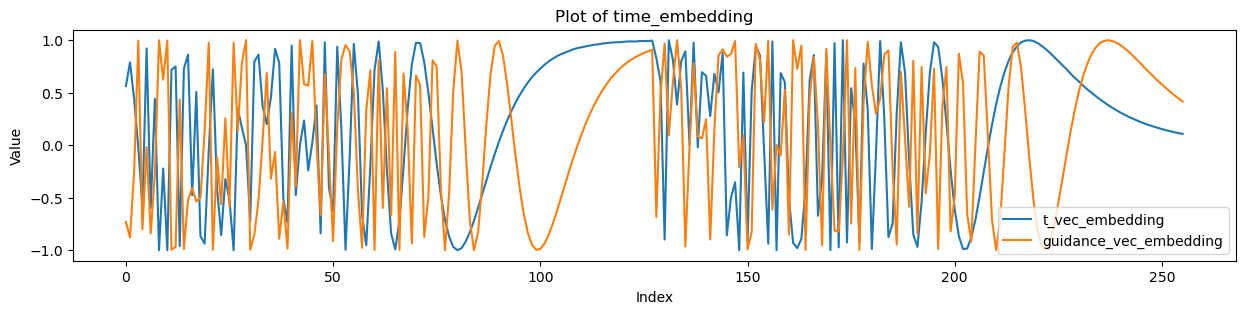

In [19]:
t_vec_embedding = timestep_embedding(t_vec, 256)
guidance_vec_embedding = timestep_embedding(guidance_vec, 256)

plt.figure(figsize=(15, 3))
t_vec_embedding_np = t_vec_embedding[0].float().cpu().numpy()
guidance_vec_embedding_np = guidance_vec_embedding[0].float().cpu().numpy()

# Plotting odd and even indexed elements
plt.plot(t_vec_embedding_np, label='t_vec_embedding')
plt.plot(guidance_vec_embedding_np, label='guidance_vec_embedding')
plt.legend()
plt.title('Plot of time_embedding')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

### RoPE位置编码

这里简单介绍一下 RoPE 位置编码，它是一种相对位置编码，能够表示 token 之间的相对距离。一个普遍的位置编码是在现有向量的基础上增加位置信息，表示为：
$$
\tilde{q}_m = f(q, m)
$$


RoPE 的思路是通过借助复数的性质，从而“通过绝对位置编码的方式实现相对位置编码”。针对相对位置，其目标是实现在 Attention 内积计算时存在：
$$
⟨f(q,m),f(k,n)⟩=g(q,k,m−n)
$$

我们借助复数和欧拉公式，推导（过程略）出如下形式能够满足上述目标：
$$
⟨q e^{i n \theta}, k e^{i m \theta}⟩ = ⟨q, k⟩ e^{i(m-n)\theta}
$$

根据复数乘法的几何意义，该变换实际上对应着向量的旋转，它可以写成矩阵形式：
$$
e^{i\theta}(x + iy) \Rightarrow 
\begin{bmatrix}
\cos\theta & -\sin\theta \\
\sin\theta & \cos\theta
\end{bmatrix}
\begin{bmatrix}
x \\
y
\end{bmatrix}
$$

扩展到多维里，有：

$$
\scriptsize{\underbrace{\begin{pmatrix} 
\cos m\theta_0 & -\sin m\theta_0 & 0 & 0 & \cdots & 0 & 0 \\ 
\sin m\theta_0 & \cos m\theta_0 & 0 & 0 & \cdots & 0 & 0 \\ 
0 & 0 & \cos m\theta_1 & -\sin m\theta_1 & \cdots & 0 & 0 \\ 
0 & 0 & \sin m\theta_1 & \cos m\theta_1 & \cdots & 0 & 0 \\ 
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\ 
0 & 0 & 0 & 0 & \cdots & \cos m\theta_{d/2-1} & -\sin m\theta_{d/2-1} \\ 
0 & 0 & 0 & 0 & \cdots & \sin m\theta_{d/2-1} & \cos m\theta_{d/2-1} \\ 
\end{pmatrix}}_{\boldsymbol{\mathcal{R}}_m} \begin{pmatrix}q_0 \\ q_1 \\ q_2 \\ q_3 \\ \vdots \\ q_{d-2} \\ q_{d-1}\end{pmatrix}}
$$

从而满足：
$$
(R_m q)^T (R_n k) = q^T R_{n−m} k
$$

在具体的实现上，我们考虑到内积满足线性叠加性以及旋转矩阵本身的稀疏性，有：

$$
\begin{pmatrix}q_0 \\ q_1 \\ q_2 \\ q_3 \\ \vdots \\ q_{d-2} \\ q_{d-1} 
\end{pmatrix}\otimes\begin{pmatrix}\cos m\theta_0 \\ \cos m\theta_0 \\ \cos m\theta_1 \\ \cos m\theta_1 \\ \vdots \\ \cos m\theta_{d/2-1} \\ \cos m\theta_{d/2-1} 
\end{pmatrix} + \begin{pmatrix}-q_1 \\ q_0 \\ -q_3 \\ q_2 \\ \vdots \\ -q_{d-1} \\ q_{d-2} 
\end{pmatrix}\otimes\begin{pmatrix}\sin m\theta_0 \\ \sin m\theta_0 \\ \sin m\theta_1 \\ \sin m\theta_1 \\ \vdots \\ \sin m\theta_{d/2-1} \\ \sin m\theta_{d/2-1} 
\end{pmatrix}
$$

其中 $\theta_i$ 沿用了Sinusoidal位置编码的方案，即 $\theta_i = 10000^{−2i/d}$。

In [20]:
def rope(pos: Tensor, dim: int, theta: int) -> Tensor:
    assert dim % 2 == 0
    scale = torch.arange(0, dim, 2, dtype=pos.dtype, device=pos.device) / dim
    omega = 1.0 / (theta**scale)
    out = torch.einsum("...n,d->...nd", pos, omega)
    out = torch.stack([torch.cos(out), -torch.sin(out), torch.sin(out), torch.cos(out)], dim=-1)
    out = rearrange(out, "b n d (i j) -> b n d i j", i=2, j=2)
    return out.float()

ids = torch.cat((txt_ids, img_ids), dim=1)  # (bs, 512+1024, 3)
n_axes = ids.shape[-1]  # 3

flux_params.axes_dim # a list = [16, 56, 56]
flux_params.theta # = 10000

pe = torch.cat(
    [rope(ids[..., i], flux_params.axes_dim[i], flux_params.theta) for i in range(n_axes)],
    dim=-3,
).unsqueeze(1)  # [batch_size, 1, sequence_length, dim/2, 2, 2]

这里的 `pe` 就是 $R_m$，它以 dim/2 个 (2, 2) 旋转矩阵的方式存储。
对于原始的 3 维位置表示，分别对应 [16, 56, 56] 维。

### 总结

到此，我们就完成了网络的预处理部分：

![](https://image-1304830922.cos.ap-shanghai.myqcloud.com/20250303155941221.png)

In [21]:
print(img.size(), txt.size(), vec.size(), pe.size())

torch.Size([2, 1024, 3072]) torch.Size([2, 512, 3072]) torch.Size([2, 3072]) torch.Size([2, 1, 1536, 64, 2, 2])


## 网络 - DoubleStream

接下来就是网络中最重要的两个模块了，DualStream 和 SingleStream。我们先分析 DualStream。

![](https://image-1304830922.cos.ap-shanghai.myqcloud.com/20250303161607441.png)

In [22]:
block = model.double_blocks[0]
img, txt = block(img=img, txt=txt, vec=vec, pe=pe)

from torchinfo import summary

res = summary(block,
        input_data=[img, txt, vec, pe],
        col_names=["input_size", "output_size", "num_params", "params_percent"],
        row_settings=["var_names"],
        depth=10,
        verbose=1,
)

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Param %
DoubleStreamBlock (DoubleStreamBlock)    [2, 1024, 3072]           [2, 1024, 3072]           --                             --
├─Modulation (img_mod)                   [2, 3072]                 --                        --                             --
│    └─Linear (lin)                      [2, 3072]                 [2, 18432]                56,641,536                 16.67%
├─Modulation (txt_mod)                   [2, 3072]                 --                        --                             --
│    └─Linear (lin)                      [2, 3072]                 [2, 18432]                56,641,536                 16.67%
├─LayerNorm (img_norm1)                  [2, 1024, 3072]           [2, 1024, 3072]           --                             --
├─SelfAttention (img_attn)               --                        --                        (recursive)       

我们把 DoubleStreamBlock 的 forward 拿出来分析。

### Modulation

这里的 Modulation（调制） 对应的是 DiT 中的 AdaLN_Zero，生成三个调制变量：`shift`, `scale`, `gate`，分别用于调特征的均值、方差，以及作为门控。

![](https://image-1304830922.cos.ap-shanghai.myqcloud.com/20250303171049153.png)

In [23]:
from dataclasses import dataclass

@dataclass
class ModulationOut:
    shift: Tensor
    scale: Tensor
    gate: Tensor


class Modulation(nn.Module):
    def __init__(self, dim: int, double: bool):
        super().__init__()
        self.is_double = double
        self.multiplier = 6 if double else 3
        self.lin = nn.Linear(dim, self.multiplier * dim, bias=True)

    def forward(self, vec: Tensor) -> tuple[ModulationOut, ModulationOut | None]:
        out = self.lin(nn.functional.silu(vec))[:, None, :].chunk(self.multiplier, dim=-1)

        return (
            ModulationOut(*out[:3]),
            ModulationOut(*out[3:]) if self.is_double else None,
        )
        
img_mod1, img_mod2 = block.img_mod(vec)
txt_mod1, txt_mod2 = block.txt_mod(vec)

In [24]:
print(img_mod1.shift.size(), img_mod1.scale.size(), img_mod1.gate.size())

torch.Size([2, 1, 3072]) torch.Size([2, 1, 3072]) torch.Size([2, 1, 3072])


### QKV

接下来就是`img`和`txt`经过调制再经过的各自的 LayerNorm，并算出 qkv。

![](https://image-1304830922.cos.ap-shanghai.myqcloud.com/20250303173422813.png)

注意，这里虽然用了 img_attn = SelfAttention，但实际上只是用了其中的参数，而最终的计算是放在后面的。即一个 DoubleStreamBlock 只执行了一次真正的 attention。

针对 Q 和 K 这里做了一次 RMSNorm，主要是为了确保在高分辨率下的训练稳定性。
RMSNorm 是一个 LayerNorm 的变体，不再计算均值+方差，而只计算**均方根**，如下：

| 步骤               | LayerNorm                          | RMSNorm                     |
|--------------------|------------------------------------|-----------------------------|
| 均值计算           | $\mu = \frac{1}{d} \sum x_k$    | 无                      |
| 方差计算           | $\sigma^2 = \frac{1}{d} \sum (x_k - \mu)^2$ | 无               |
| 归一化值           | $\gamma_k \cdot \frac{x_k - \mu}{\sigma} + \beta_k $       | $\gamma_k \cdot \frac{x_k}{\text{RMS}}$  |
| 可学习参数         | $\gamma_k, \beta_k$              | $\gamma_k$                |

RMSNorm 的核心优势在于速度比较快。


In [25]:
# prepare image for attention
img_modulated = block.img_norm1(img)
img_modulated = (1 + img_mod1.scale) * img_modulated + img_mod1.shift
img_qkv = block.img_attn.qkv(img_modulated)
# B=batch_size, L=seq_len, K=3 (qkv), H=num_heads, D=hidden_size/num_heads
img_q, img_k, img_v = rearrange(img_qkv, "B L (K H D) -> K B H L D", K=3, H=block.num_heads)
img_q, img_k = block.img_attn.norm(img_q, img_k, img_v)

# prepare txt for attention
txt_modulated = block.txt_norm1(txt)
txt_modulated = (1 + txt_mod1.scale) * txt_modulated + txt_mod1.shift
txt_qkv = block.txt_attn.qkv(txt_modulated)
txt_q, txt_k, txt_v = rearrange(txt_qkv, "B L (K H D) -> K B H L D", K=3, H=block.num_heads)
txt_q, txt_k = block.txt_attn.norm(txt_q, txt_k, txt_v)

In [26]:
txt_q.size()  # bs=2, num_heads=24, seq_len=512, dim=3072/24=128

torch.Size([2, 24, 512, 128])

### Attention w/ RoPE

如下，这里核心的是将上节中所将的旋转位置编码加到 q,k 上，然后这里调用了最原始的 F.scaled_dot_product_attention 进行 attention 的计算。

针对 img 和 txt，在 attention 前后分别 concat 和 split。

In [27]:

def apply_rope(xq: Tensor, xk: Tensor, freqs_cis: Tensor) -> tuple[Tensor, Tensor]:
    xq_ = xq.float().reshape(*xq.shape[:-1], -1, 1, 2)
    xk_ = xk.float().reshape(*xk.shape[:-1], -1, 1, 2)
    xq_out = freqs_cis[..., 0] * xq_[..., 0] + freqs_cis[..., 1] * xq_[..., 1]
    xk_out = freqs_cis[..., 0] * xk_[..., 0] + freqs_cis[..., 1] * xk_[..., 1]
    return xq_out.reshape(*xq.shape).type_as(xq), xk_out.reshape(*xk.shape).type_as(xk)


def attention(q: Tensor, k: Tensor, v: Tensor, pe: Tensor) -> Tensor:
    q, k = apply_rope(q, k, pe)

    x = torch.nn.functional.scaled_dot_product_attention(q, k, v)
    x = rearrange(x, "B H L D -> B L (H D)")

    return x

# run actual attention
q = torch.cat((txt_q, img_q), dim=2)
k = torch.cat((txt_k, img_k), dim=2)
v = torch.cat((txt_v, img_v), dim=2)

attn = attention(q, k, v, pe=pe)
txt_attn, img_attn = attn[:, : txt.shape[1]], attn[:, txt.shape[1] :]

In [28]:
print(txt_attn.size(), img_attn.size())

torch.Size([2, 512, 3072]) torch.Size([2, 1024, 3072])


### Post-Attention

在做完 Attention 后还有些收尾的工作，主要是进行linear、门控、Norm、调制、残差。

![](https://image-1304830922.cos.ap-shanghai.myqcloud.com/20250303173719212.png)

In [29]:
# calculate the img bloks
img = img + img_mod1.gate * block.img_attn.proj(img_attn)
img = img + img_mod2.gate * block.img_mlp((1 + img_mod2.scale) * block.img_norm2(img) + img_mod2.shift)

# calculate the txt bloks
txt = txt + txt_mod1.gate * block.txt_attn.proj(txt_attn)
txt = txt + txt_mod2.gate * block.txt_mlp((1 + txt_mod2.scale) * block.txt_norm2(txt) + txt_mod2.shift)

## 网络 - SingleStream

SingleStream 的主要网络结构和 DoubleStream 很像。但是这里注意有两点变化：1. SingleStream 在 attention 的时候额外计算了一个 mlp； 2. 在最后输出的地方， DoubleStream 对每个分支做了一个 mlp (因而 double 有两组调制，而 single 只有一组)。

![](https://image-1304830922.cos.ap-shanghai.myqcloud.com/20250303185806342.png)

In [30]:
block = model.single_blocks[0]

img = torch.cat((txt, img), 1)
img = block(img, vec=vec, pe=pe)

In [31]:
mod, _ = block.modulation(vec)
x_mod = (1 + mod.scale) * block.pre_norm(img) + mod.shift
qkv, mlp = torch.split(block.linear1(x_mod), [3 * block.hidden_size, block.mlp_hidden_dim], dim=-1)

q, k, v = rearrange(qkv, "B L (K H D) -> K B H L D", K=3, H=block.num_heads)
q, k = block.norm(q, k, v)

# compute attention
attn = attention(q, k, v, pe=pe)
# compute activation in mlp stream, cat again and run second linear layer
output = block.linear2(torch.cat((attn, block.mlp_act(mlp)), 2))

img = img + mod.gate * output

## 网络 - LastLayer

在 SingleStream 的输出之后，稍加处理即可作为最终的输出了。

![](https://image-1304830922.cos.ap-shanghai.myqcloud.com/20250303193407473.png)

In [32]:
img = img[:, txt.shape[1] :, ...]
img = model.final_layer(img, vec)

## VAE-Decoder

In [33]:
height, width = 512, 512

x = rearrange(
        img.float(),
        "b (h w) (c ph pw) -> b c (h ph) (w pw)",
        h=math.ceil(height / 16),
        w=math.ceil(width / 16),
        ph=2,
        pw=2,
    )

In [34]:
from flux.modules.autoencoder import AutoEncoder
from dataclasses import dataclass 

@dataclass
class AutoEncoderParams:
    resolution: int
    in_channels: int
    ch: int
    out_ch: int
    ch_mult: list[int]
    num_res_blocks: int
    z_channels: int
    scale_factor: float
    shift_factor: float


ae_params=AutoEncoderParams(
    resolution=256,
    in_channels=3,
    ch=128,
    out_ch=3,
    ch_mult=[1, 2, 4, 4],
    num_res_blocks=2,
    z_channels=16,
    scale_factor=0.3611,
    shift_factor=0.1159,
)

# Loading the autoencoder
ae = AutoEncoder(ae_params).to(torch_device)

with torch.autocast(device_type=torch_device.type, dtype=torch.bfloat16):
    final = ae.decode(x)

## 参考

1. [black-forest-labs/flux - github](https://github.com/black-forest-labs/flux)
2. [FLUX.1 源码深度前瞻解读 - 周弈帆](https://zhouyifan.net/2024/09/03/20240809-flux1/)
3. [Flux.1架构探究 - 吃亚索的土拨鼠](https://zhuanlan.zhihu.com/p/721904009)
4. [博采众长的旋转式位置编码 - 苏剑林](https://kexue.fm/archives/8265)
5. [Diffusion Transformer模型结构简析（DiT、SD3、Flux）](https://zhuanlan.zhihu.com/p/6853326128)
6. [FLUX.1 原理与源码解析 - 从越](https://zhuanlan.zhihu.com/p/741939590)
7. [深入浅出完整解析Stable Diffusion 3（SD 3）和FLUX.1系列核心基础知识 - Rocky Ding](https://zhuanlan.zhihu.com/p/684068402)
8. [扩散模型之DiT：纯Transformer架构 - 小小将](https://zhuanlan.zhihu.com/p/641013157)